In [12]:
import pandas as pd

df_invoice = pd.read_csv('fct_invoice.csv')

In [13]:
df_invoice.head()

,invoice_no,customer_id,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,229,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,3433,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,644,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,4900,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,1089,Books,4,60.60,Cash,24/10/2021,Kanyon


In [14]:
df_customers = pd.read_json('dim_customer.json')

In [15]:
df_customers.head()

,age,first_name,gender,id,last_name
0,48.0,Nicholas,M,0,Flores
1,NaN,Jeffery,M,1,Rowe
2,57.0,Alexis,F,2,Benton
3,73.0,Amy,F,3,Johnson
4,20.0,David,M,4,Moore


In [16]:
unique_customers = df_customers['id'].nunique()

easy_1 = "Unique customers: " + str(unique_customers)

print(easy_1)

Unique customers: 5191


In [17]:
categories = df_invoice['category'].unique()

easy_2a = "Product categories: " + str(categories)
easy_2b = "Number of categories: " + str(len(categories))

print(easy_2a)
print(easy_2b)

Product categories: ['Clothing' 'Shoes' 'Books' 'Cosmetics' 'Food & Beverage' 'Toys'
 'Technology' 'Souvenir']
Number of categories: 8


In [18]:
payments = df_invoice['payment_method'].value_counts()
popular_count = payments.max()
popular_method = payments.idxmax()

easy_3 = "Most popular payment method: " + str(popular_method) + " used " + str(popular_count) + " times"
print(easy_3)

Most popular payment method: Cash used 44447 times


In [20]:
df_invoice['total_sales'] = df_invoice['price'] * df_invoice['quantity']
category_sales = df_invoice.groupby('category')['total_sales'].sum()

top_3 = category_sales.sort_values(ascending=False).head(3)

top_3_categories = ", ".join([f"{cat} ({price:,.2f})" for cat, price in top_3.items()])

medium_1 = "Top 3 categories by total sales: " + str(top_3_categories)
print(medium_1)

Top 3 categories by total sales: Clothing (113,996,791.04), Shoes (66,553,451.47), Technology (57,862,350.00)


In [21]:
df_combined = pd.merge(df_invoice, df_customers[['id','age']], left_on = 'customer_id', right_on ='id')
sales_age_45 = df_combined[df_combined['age']>45]['total_sales'].sum()
medium_2 = "Total sales for customers over the age of 45: " + str(sales_age_45)

print(medium_2)

Total sales for customers over the age of 45: 82039768.15


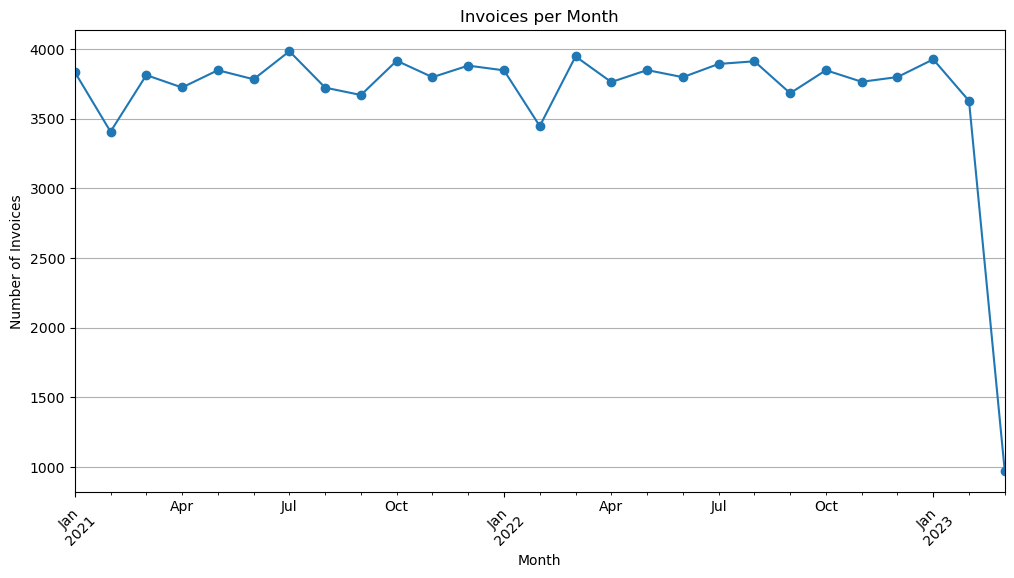

There are visible dips in the plot after January (starting February) across all three years. May and October also seemed to get more invoices compared to the month before and after it for both years.


In [22]:
import matplotlib.pyplot as plt
import pandas as pd

df_invoice['invoice_date'] = pd.to_datetime(df_invoice['invoice_date'],dayfirst = True)

sales_per_month = df_invoice.groupby(pd.Grouper(key='invoice_date', freq='ME'))['invoice_no'].nunique()

sales_per_month.plot(kind='line', figsize=(12,6), title='Invoices per Month', marker = 'o')
plt.xlabel('Month')
plt.ylabel('Number of Invoices')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

medium_2 = "There are visible dips in the plot after January (starting February) across all three years. May and October also seemed to get more invoices compared to the month before and after it for both years."
print(medium_2)

In [33]:
df_combined['age_decade'] = (df_combined['age'] // 10) * 10
df_combined['age_range'] = df_combined['age_decade'].astype(str) +'-' + (df_combined['age_decade'] + 9).astype(str)

pivot = pd.pivot_table(
    df_combined,
    values='total_sales',
    index='category',
    columns='age_range',
    aggfunc='sum',
    fill_value=0
)

nan_nan_col = 'nan-nan'
if nan_nan_col in pivot.columns:
    pivot['Subtotal (Excl nan-nan)'] = pivot.loc[:, pivot.columns != nan_nan_col].sum(axis=1)
else:
    pivot['Subtotal (Excl nan-nan)'] = pivot.sum(axis=1)
    pivot['Total (Incl nan-nan)'] = pivot['Subtotal (Excl nan-nan)']

age_range_cols = [col for col in pivot.columns if col not in ['Subtotal (Excl nan-nan)', 'Total (Incl nan-nan)']]
pivot['Grand Total'] = pivot[age_range_cols].sum(axis=1)

totals_row = pivot.sum(axis=0)
totals_row.name = 'Total'

pivot = pd.concat([pivot, totals_row.to_frame().T])
pivot.style.format("{:,.2f}")

age_range,10.0-19.0,20.0-29.0,30.0-39.0,40.0-49.0,50.0-59.0,60.0-69.0,70.0-79.0,80.0-89.0,nan-nan,Subtotal (Excl nan-nan),Grand Total
Books,"12,801.75","79,461.75","84,143.10","87,203.40","74,962.20","80,476.80","54,827.85","26,664.00","334,012.05","500,540.85","834,552.90"
Clothing,"1,927,413.84","10,250,732.80","11,354,126.96","11,215,189.92","10,321,851.76","10,660,642.08","7,769,371.28","4,493,698.00","46,003,764.40","67,993,026.64","113,996,791.04"
Cosmetics,"109,619.36","605,915.32","723,544.70","665,034.96","587,780.96","649,990.76","419,082.62","254,531.60","2,777,362.62","4,015,500.28","6,792,862.90"
Food & Beverage,"13,582.31","73,491.96","87,246.86","89,553.29","72,425.04","80,976.09","55,050.98","31,332.93","345,875.59","503,659.46","849,535.05"
Shoes,"993,281.35","5,924,878.24","7,200,839.66","7,025,590.02","5,852,857.84","5,978,893.54","4,480,269.05","2,628,744.60","26,468,097.17","40,085,354.30","66,553,451.47"
Souvenir,"12,375.15","54,943.32","64,092.72","66,391.80","54,943.32","55,025.43","38,673.81","23,718.06","265,661.04","370,163.61","635,824.65"
Technology,"1,129,800.00","5,261,550.00","6,159,300.00","5,954,550.00","4,435,200.00","5,471,550.00","3,638,250.00","1,946,700.00","23,865,450.00","33,996,900.00","57,862,350.00"
Toys,"60,426.24","385,100.80","420,582.40","390,906.88","345,067.52","363,955.20","273,244.16","153,932.80","1,587,210.24","2,393,216.00","3,980,426.24"
Total,"4,259,300.00","22,636,074.19","26,093,876.40","25,494,420.27","21,745,088.64","23,341,509.90","16,728,769.75","9,559,321.99","101,647,433.11","149,858,361.14","251,505,794.25"
